# Figure 4: Radial for RKD Electrons ($\alpha=0.3$)

This notebook reproduces **Figure 4** from the paper  
**"Kinetic-based macro-modeling of the solar wind at large heliocentric distances: Kappa electrons at the exobase"**  
(submitted to *JGR–Space Physics*).

alpha=0.3, kappa=0.5, B0_over_C0=0.0688682166806758
alpha=0.3, kappa=1.5, B0_over_C0=0.0617947795893752
alpha=0.3, kappa=3.0, B0_over_C0=0.0612476375192739
alpha=0.3, kappa=10.0, B0_over_C0=0.0655384134395255
alpha=0.3, kappa=100.0, B0_over_C0=0.0659717027101627
alpha=0.3, kappa=0.5, T_convertion_factor=2.89658620811553
alpha=0.3, kappa=1.5, T_convertion_factor=1.84363862671148
alpha=0.3, kappa=3.0, T_convertion_factor=1.36665599953092
alpha=0.3, kappa=10.0, T_convertion_factor=1.03564558493027
alpha=0.3, kappa=100.0, T_convertion_factor=0.928413048994698


/var/folders/yf/bhm7115535n8zj8mfplb9pfm0000gp/T/ipykernel_28659/3526905539.py:236: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


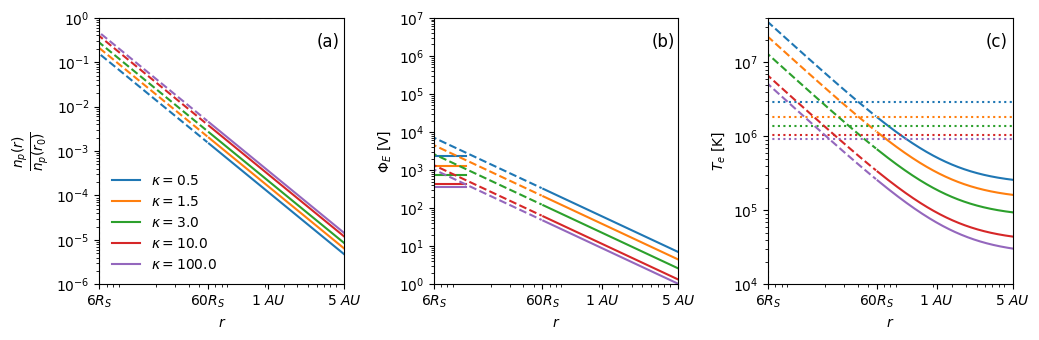

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy.special import erfcx, gamma
import mpmath as mp

# --- Physical constants ---
kB = constants.k            # Boltzmann constant [J/K]
m_e = constants.m_e         # Electron mass [kg]
m_p = constants.m_p         # Proton mass [kg]
e_charge = constants.e      # Elementary charge [C]
G = 6.674e-11               # Gravitational constant [SI]
R_sun = 6.957e8             # Solar radius [m]
M_sun = 1.989e30            # Solar mass [kg]
AU = 149597870.7 * 1000     # Astronomic unit [m]
pi = np.pi

# --- Temperatures (K) ---
T_e = 1e6
T_p = 2e6

# --- Thermal velocities ---
theta_e2 = 2 * kB * T_e / m_e
theta_p2 = 2 * kB * T_p / m_p
theta_e = np.sqrt(theta_e2)
theta_p = np.sqrt(theta_p2)

# --- Gravitational potential at solar surface ---
Phi_G = m_p * G * M_sun / (6 * R_sun)

# Reference values 
kappa_values = [0.5, 1.5, 2, 3, 10, 100]

#______________ alpha=0.3
y_exact_alpha03 = np.asarray([53.98, 10.019, 6.00817, 2.9389, 0.50733, 0.040869758])
phi_exact_alpha03 = np.asarray([2325.819, 1295.057, 1035.489, 759.76, 437.1854, 352.188])
V_p0_alpha03 = np.sqrt(2/m_p*(e_charge*phi_exact_alpha03 - Phi_G))

#____________remove the case for kappa=2
kappa_values=np.delete(kappa_values,2)
y_exact_alpha03=np.delete(y_exact_alpha03,2)
phi_exact_alpha03=np.delete(phi_exact_alpha03 ,2)
V_p0_alpha03=np.delete(V_p0_alpha03,2)

# Radial grid
r = np.linspace(R_sun, 5 * AU, 500)
eta = (6 * R_sun / r) ** 2

# --- Stable P(x) using erfcx ---
def P(x):
    """
    Stable evaluation of:
    P(x) = sqrt(pi) * (0.5 - x^2) * erfcx(x) + x
    where erfcx(x) = exp(x^2) * erfc(x)
    """
    x = np.asarray(x, dtype=float)
    return np.sqrt(np.pi) * (0.5 - x**2) * erfcx(x) + x

def compute_D0(V0, N_e_at_r0=1.0, Te=1e6, alpha=0.1, kappa=2.0):
    """
    Compute parameter D0 directly from distribution function.
    """
    we = np.sqrt(2 * kB * Te / m_e)
    U_val = mp.hyperu(1.5, 1.5 - kappa, alpha**2 * kappa)
    C_RKD = N_e_at_r0 / ((pi * we**2 * kappa) ** 1.5 * U_val)
    f_val = C_RKD * (1.0 + V0**2 / (kappa * we**2)) ** (-kappa - 1.0) * np.exp(-(alpha**2 * V0**2) / we**2)
    return (4.0 * pi / 3.0) * f_val

def compute_B0(V0, Ne_r0=1.0, w_e=5.5e6, alpha=0.1 , kappa=2.0):
    """
    Compute B0 numerically using substitution u^2 = v^2 - V0^2.
    """
    # Define Tricomi confluent hypergeometric U(a,b,z)
    U = mp.hyperu

    # Normalization constant C_RKD
    C_RKD = Ne_r0 / (
        (mp.pi * w_e**2 * kappa)**1.5
        * U(1.5, 1.5 - kappa, alpha**2 * kappa)
    )

    # Define the integrand after substitution u^2 = v^2 - V0^2
    def integrand(u):
        return (
            (u**2 + V0**2)
            * (1 + (u**2 + V0**2) / (kappa * w_e**2))**(-kappa - 1)
            * mp.e**(-(alpha**2 * (u**2 + V0**2)) / (w_e**2))
        )

    # Perform numerical integration from 0 to infinity
    integral_val = mp.quad(integrand, [0, mp.inf])

    # Final result
    return mp.pi * C_RKD * integral_val

def compute_B2(V0, Ne_r0=1.0, w_e=5.5e6, alpha=0.1, kappa=2.0):
    """
    Compute B2 integral.
    """
    # Define Tricomi confluent hypergeometric U(a,b,z)
    U = mp.hyperu

    # Normalization constant C_RKD
    C_RKD = Ne_r0 / (
        (mp.pi * w_e**2 * kappa)**1.5 *
        U(1.5, 1.5 - kappa, alpha**2 * kappa)
    )

    # Define the integrand after substitution u^2 = v^2 - V0^2
    def integrand(u):
        v_sq = u**2 + V0**2
        return (
            v_sq * u**2 *  # v^3 * sqrt(v^2 - V0^2) dv = (u^2 + V0^2) * u^2 du
            (1 + v_sq / (kappa * w_e**2))**(-kappa - 1) *
            mp.exp(-alpha**2 * v_sq / w_e**2)
        )

    # Perform numerical integration from 0 to infinity
    integral_val = mp.quad(integrand, [0, mp.inf])

    # Final result
    return mp.pi * C_RKD * integral_val

n_p_at_r0 = 1
n_e_at_r0 = 1

# Create figure with 3 panels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10.5, 3.5 ), constrained_layout=True)
colors = ["C0", "C1", "C2", "C3", "C4", "C6"]

# Panel 1: Density profiles
for i, (kappa_val, y_exact, phi_exact, V_p0) in enumerate(
    zip(kappa_values, y_exact_alpha03, phi_exact_alpha03, V_p0_alpha03)
):
    C0 = n_p_at_r0 / np.sqrt(np.pi) * P(V_p0 / theta_p)
    Density = C0 * eta
    r_norm = r / R_sun
    mask = r_norm < 60
    
    ax1.plot(r_norm[mask], Density[mask], linestyle="--", color=colors[i])
    ax1.plot(r_norm[~mask], Density[~mask], linestyle="-", color=colors[i],
             label=fr"$\kappa={kappa_val}$")

ax1.set_ylabel(r"$\frac{n_{p}(r)}{n_{p}(r_0)}$",fontsize=14)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.axhline(1, color="gray", linestyle="--")
ax1.axvline(6, color="gray", linestyle=":")
mask2 = r_norm < 12
AU_in_Rsun = AU / R_sun
xticks_vals = [6, 60, AU_in_Rsun, 5*AU_in_Rsun]
xticks_labels = [r"$6R_S$", r"$60R_S$", r"$1\ AU$", r"$5\ AU$"]
ax1.set_xticks(xticks_vals)
ax1.set_xticklabels(["","","",""])
ax1.set_xlim(6, 5*AU_in_Rsun)
ax1.set_ylim(1e-6, 1)
ax1.text(0.89, 0.89, "(a)", transform=ax1.transAxes, fontsize=12)
ax1.set_xlabel(r"$r$") #\ [R_S]
ax1.set_xticklabels(xticks_labels)
ax1.legend(frameon=False)

# Panel 2: Electrostatic potential
for i, (kappa_val, y_exact, phi_exact, V_p0) in enumerate(
    zip(kappa_values, y_exact_alpha03, phi_exact_alpha03, V_p0_alpha03)
):
    C0 = n_p_at_r0 / np.sqrt(np.pi) * P(V_p0 / theta_p)
    V0 = np.sqrt(2*e_charge*phi_exact/m_e)
    D0 = compute_D0(V0=V0, N_e_at_r0=n_e_at_r0, Te=T_e, alpha=0.3, kappa=kappa_val)
    B0 = compute_B0(V0=V0, Ne_r0=n_e_at_r0, w_e=theta_e, alpha=0.3, kappa=kappa_val)

    print(f"alpha={0.3}, kappa={kappa_val}, B0_over_C0={B0/C0}")
    
    r_norm = r / R_sun
    mask = r_norm < 60

    # Phi radial profile
    Phi_E_radial_profile_new = m_e * (eta * (C0 - B0) / D0) ** (2 / 3) / (2 * e_charge)

    ax2.plot(r_norm[mask], Phi_E_radial_profile_new[mask], linestyle="--", color=colors[i])
    ax2.plot(r_norm[~mask], Phi_E_radial_profile_new[~mask], linestyle="-", color=colors[i],
             label=fr"$\kappa={kappa_val}$")

    ax2.plot(r_norm[mask2],phi_exact_alpha03[i]*np.ones(np.size(r_norm))[mask2], linestyle="-", color=colors[i])


ax2.set_ylabel(r"$\Phi_E$ [V]")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.axvline(6, color="gray", linestyle=":")
ax2.set_xticks(xticks_vals)
ax2.set_xticklabels(["","","",""])
ax2.set_xlim(6, 5*AU_in_Rsun)
ax2.set_ylim(1, 1e7)
ax2.text(0.89, 0.89, "(b)", transform=ax2.transAxes, fontsize=12)
ax2.set_xlabel(r"$r$") #\ [R_S]
ax2.set_xticklabels(xticks_labels)

U = mp.hyperu
# Panel 3: Electron temperature
for i, (kappa_val, y_exact, phi_exact, V_p0) in enumerate(
    zip(kappa_values, y_exact_alpha03, phi_exact_alpha03, V_p0_alpha03)
):
    C0 = n_p_at_r0 / np.sqrt(np.pi) * P(V_p0 / theta_p)
    V0 = np.sqrt(2*e_charge*phi_exact/m_e)
    D0 = compute_D0(V0=V0, N_e_at_r0=n_e_at_r0, Te=T_e, alpha=0.3, kappa=kappa_val)
    B2 = compute_B2(V0=V0, Ne_r0=n_e_at_r0, w_e=theta_e, alpha=0.3, kappa=kappa_val)
    
    r_norm = r / R_sun
    mask = r_norm < 60

    T_43 = m_e/(5*kB) * (C0/D0)**(2/3) * eta**(2/3)
    T_C = m_e*B2/(3*kB*C0)
    Te_radial_profile = T_C + T_43

    ax3.plot(r_norm[mask], Te_radial_profile[mask], linestyle="--", color=colors[i])
    ax3.plot(r_norm[~mask], Te_radial_profile[~mask], linestyle="-", color=colors[i],
             label=fr"$\kappa={kappa_val}$")

    alpha_val=0.3
    T_convertion_factor=kappa_val*U(5/2,5/2-kappa_val,alpha_val**2*kappa_val)/U(3/2,3/2-kappa_val,alpha_val**2*kappa_val)
    ax3.plot(r_norm, T_convertion_factor*T_e*np.ones(np.size(r_norm)), linestyle=":", color=colors[i])
    print(f"alpha={alpha_val}, kappa={kappa_val}, T_convertion_factor={T_convertion_factor}")

ax3.set_ylabel(r"$T_e$ [K]")
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.axvline(6, color="gray", linestyle=":")
ax3.set_xticks(xticks_vals)
ax3.set_xticklabels(xticks_labels)
ax3.set_xlabel(r"$r$") 
ax3.set_xlim(6, 5*AU_in_Rsun)
ax3.set_ylim(1e4, 4e7)
ax3.text(0.89, 0.89, "(c)", transform=ax3.transAxes, fontsize=12)


plt.tight_layout()
plt.savefig("Figure_4.pdf", bbox_inches="tight")
plt.show()